## Mines vs Rocks SVM Classification

This notebook is a demonstration of applying a support vector machine (SVM) to solve a classification problem. 

I will train an SVM to discriminate between sonar signals bounced off a metal cylinder and those bounced off a roughly cylindrical rock.

### Load the data
First, I'll load the data set from UC Irvine's Machine Learning Repository as pandas dataframes:

In [ ]:
pip install ucimlrepo

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
sonar_data = fetch_ucirepo(id=151) 
  
# data (as pandas dataframes) 
X = sonar_data.data.features 
y = sonar_data.data.targets 

### Explore the data

We have 208 sonar signal records. Each record has 60 features with continuous values ranging from 0 to 1 representing energy or spectral density at a particular frequency band. The "Target" data also includes the true class of each object, stating whether the target object is a metal cylinder/mine as "M" or a rock as "R".

In [ ]:
# check for missing values and variable types
print(sonar_data.variables)
print(X.info())
print(y.info())

In [ ]:
# check the first five records across all features
print(X.head())
print(y.head())

In [ ]:
# check summary statistics for each feature
print(X.describe())

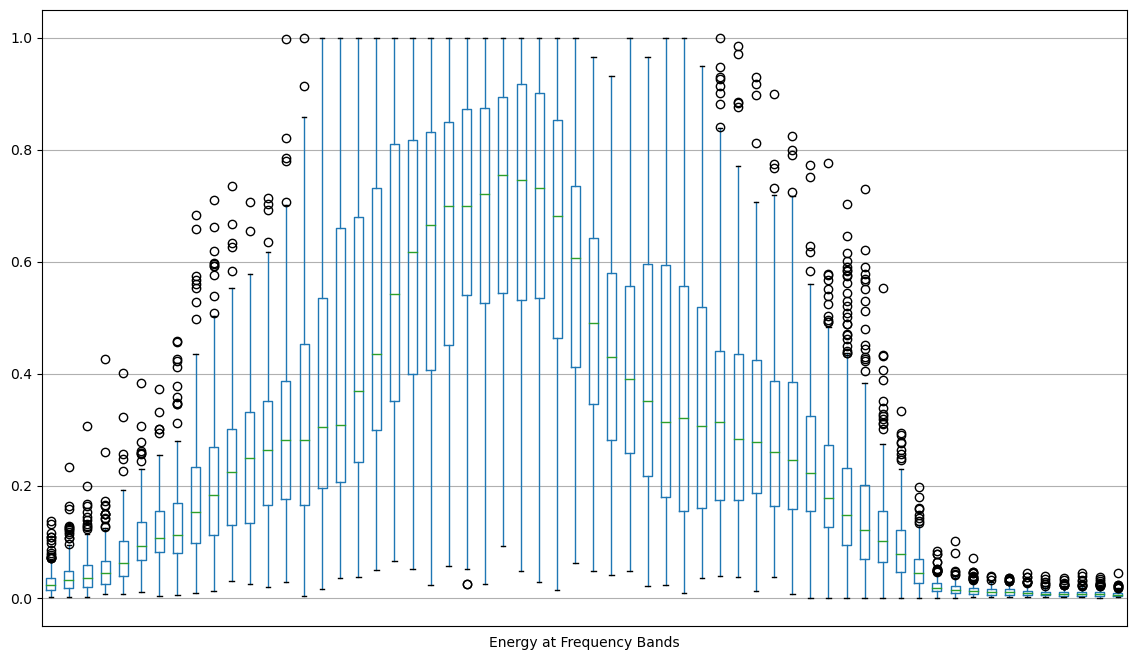

In [6]:
# create a boxplot to visualize dataset, clean up axis labels
X.boxplot(figsize=(14, 8))
plt.xticks([], [])
plt.xlabel("Energy at Frequency Bands")
plt.show()

The above boxplot shows the distribution of values at each of the 60 features across the entire dataset. I see a bell shape trend in the feature values as we move from frequency band 0 to 59. The variance increases for bands with higher mean energy. The boxplots have defined many points as outliers, but nothing looks so unusual that I would remove any data.

Next, I'll check how many objects of each class we have in the dataset and visualize how the rock sample vs mine sample means compare. Rocks will be the gray line and mines will be the red line.

In [7]:
print(y.value_counts())

class
M        111
R         97
dtype: int64


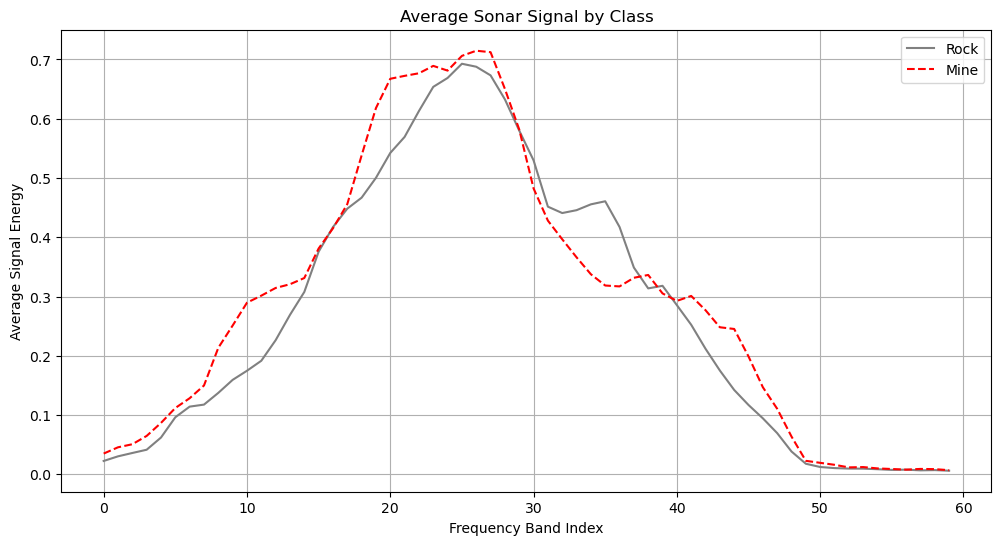

In [14]:
# create function to calculate and plot the mean values for each class
def plot_mean_classes(X, y):
    rock_mean = X[y['class'] == 'R'].mean()
    mine_mean = X[y['class'] == 'M'].mean()

    plt.figure(figsize=(12, 6))
    plt.plot(rock_mean.values, label='Rock', color='gray')
    plt.plot(mine_mean.values, label='Mine', color='red', linestyle='--')
    plt.title("Average Sonar Signal by Class")
    plt.xlabel("Frequency Band Index")
    plt.ylabel("Average Signal Energy")
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_mean_classes(X, y)

We have relatively balanced class sizes, 111 mines and 97 rocks. The mean values for rock and mine records follow the same general pattern, but there are some stark differences that our SVM classifier should be able to take advantage of. I now have a good understanding of the data structure and distribution, and found no issues such as missing values or the need for normalization.

### Training and testing splits

Now I will prepare the data for model training. I will divide the X (features) and y (true class) data into 75% training and 25% test splits with sklearn's train_test_split split.

In [9]:
from sklearn.model_selection import train_test_split

# create training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y['class'], random_state=1)

### Normalization

Next, StandardScaler is used to normalize the feature set to have zero mean and unit variance. This ensures that all features contribute equally to the model and improves the performance and convergence of the SVM algorithm.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit the scaler on training data and transform
X_train = scaler.fit_transform(X_train)

# use same transformation on test data
X_test = scaler.transform(X_test)

# inspect the test set transformation
X_df = pd.DataFrame(X_test)
print(X_df.describe())

### Model training and tuning
Next, I will train a Support Vector Machine classifier to distinguish between sonar echos from mines and rocks. We use GridSearchCV to tune the C (regularization) and gamma (kernel coefficient) hyperparameters by performing a 5-fold cross-validation across a defined parameter grid. I will use the default rbf kernel because it can capture complex, non-linear relationships between features, which are common in sonar signal patterns.

After determining the best performing combination of hyperparameters, the model is evaluated on the test set using Accuracy, Precision, and Recall. 

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

# define parameter grid to tune C and gamma values
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.25, 0.5, 1, 1.5, 2, 2.5, 3, 5, 10],
    'gamma': [0.005, 0.01, 0.015, 0.02, 0.022, 0.025, 0.03, 0.05, 0.1, 1, 'scale', 'auto']
}

# using 5-fold cross validation to choose best parameters from grid search
# use all available CPU cores in parallel
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# output best parameters and CV score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

# evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test set accuracy count:\t", accuracy_score(y_test, y_pred, normalize=False))
print("Test set accuracy:\t\t", accuracy_score(y_test, y_pred))
print("Test set precision:\t\t", precision_score(y_test, y_pred, average='weighted'))
print("Test set recall:\t\t", recall_score(y_test, y_pred, average='weighted'))


Best parameters: {'C': 2, 'gamma': 0.022}
Best cross-validated score: 0.8727822580645161
Test set accuracy count:	 44
Test set accuracy:		 0.8461538461538461
Test set precision:		 0.8537161762968215
Test set recall:		 0.8461538461538461


Based on cross-validation accuracy, the best parameter set is C = 2, and gamma = 0.22. This achieved an 87.3% cross-validation accuracy score and 84.6% accuracy when applied to the test set.

### Conclusion
After importing the dataset I observed the data types, dimensions, calculated summary statistics, checked for missing values, visualized the distibutions, and plotted the mean data each class type. Next, the records were split into 75% training and 25% testing sets. The training data was normalized so that all features have a mean of 0 and have variance in the same order. The same normalization was applied to the test data.  

Next, I instantiated an SVM classifier and initially trained it using the default parameters including an rbf kernel. To tune hyperparameters and improve the model fit, I used GridSearchCV to systematically search for the best values of C and gamma using 5-fold cross-validation. The grid search identified the best set of hyperparameters, which improved the classifier's test set accuracy to 85%, with precision and recall also achieving an 85% score.

To potentially improve classification performance, I would explore alternative classifiers such as ensemble models (Random Forests, XGBoost), or models with more advanced feature selection techniques like logistic regression with Lasso regularization.

